# 基于Transformer模型做降雨径流预报

## 导包

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime as dt, datetime
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter

In [2]:
DEVICE = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # check if GPU is available

In [3]:
#所需要的数据
pwd = os.path.abspath("..")
data_source_dir = os.path.join(pwd,"xiaoning","data","beibei_62226")

## 读取数据

In [4]:
# 读取北碚降雨数据
average_path = os.path.join(data_source_dir,"62226_pre.csv")
data_average_df = pd.read_csv(average_path)
data_average_df["total_precipitation"]=data_average_df["total_precipitation"].values*1000
data_average_df["potential_evaporation"]=data_average_df["potential_evaporation"].values*1000*(-1)
data_average_df['time_start'] = pd.to_datetime(data_average_df['time_start'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# 读取北碚观测值数据
obs_path = os.path.join(data_source_dir, "62226_str.csv")
data_obs_df = pd.read_csv(obs_path)
data_obs_df.rename(columns={'Q':'obs_Q'},inplace=True)
data_obs_df['DATE'] = pd.to_datetime(data_obs_df['DATE'], format='%Y-%m-%d %H:%M:%S')

## 绘制降雨径流相关图

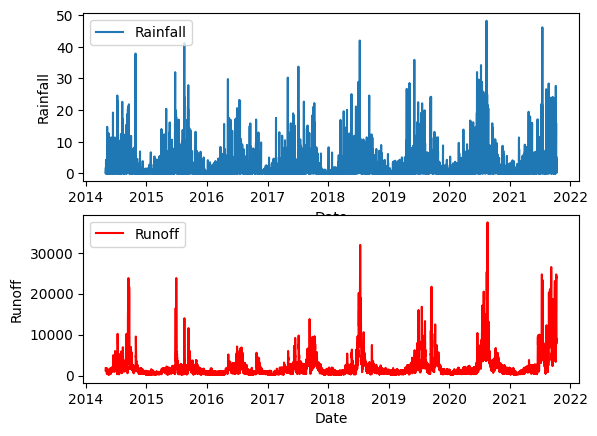

In [6]:
# 设置日期范围
date_range = pd.to_datetime(data_average_df['time_start'])

# 创建一个新的图形，包含两个子图
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# 在第一个子图中绘制降雨数据
ax1.plot(date_range, data_average_df['total_precipitation'], label='Rainfall')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rainfall')

# 在第二个子图中绘制径流数据
ax2.plot(date_range, data_obs_df['obs_Q'], color='red', label='Runoff')
ax2.set_xlabel('Date')
ax2.set_ylabel('Runoff')

# 显示图例
ax1.legend()
ax2.legend()

# 显示图形
plt.show()

## 基于Pytorch中的Dataset与Dataloader组织数据

In [7]:
class sanxiaDataset(Dataset):
    """Base data set class to load and preprocess data (batch-first) using PyTroch's Dataset"""

    def __init__(
            self,
            time: list,
            data_obs_df: pd.DataFrame,
            data_average_df: pd.DataFrame,
            loader_type: str = "train",
            seq_length: int = 2,
            means: pd.DataFrame = None,
            stds: pd.DataFrame = None,
    ):
        super(sanxiaDataset, self).__init__()
        if loader_type not in ["train", "valid", "test"]:
            raise ValueError(
                " 'loader_type' must be one of 'train', 'valid' or 'test' "
            )
        else:
            self.loader_type = loader_type
        self.time = time
        self.seq_length = seq_length

        self.means = means
        self.stds = stds

        self.data_obs_df = data_obs_df.loc[:, data_obs_df.columns == 'obs_Q']
        self.data_average_df = data_average_df.loc[:, data_average_df.columns == 'total_precipitation']

        # load and preprocess data
        self._load_data()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, item: int):
        time = self.lookup_table[item]
        seq_length = self.seq_length
        x = (
                self.x[(self.x
                        ["time"] >= time) & (self.x["time"] <= time + np.timedelta64(seq_length - 1, "h"))][
                    "total_precipitation"].values
        )

        # y = (
        #     self.y[(self.y
        #                 ["time"] >= time) & (self.y["time"] <= time + np.timedelta64(seq_length - 1, "h"))][
        #         "obs_Q"].values
        # )
        y = (
            self.y[self.y
                   ["time"] == (time + np.timedelta64(seq_length - 1, "h"))]["obs_Q"].values
        )

        x_tensor = torch.FloatTensor(x)
        y_tensor = torch.FloatTensor(y)
        return x_tensor, y_tensor

    def _create_lookup_table(self):
        """create a index table for __getitem__ functions"""
        seq_length = self.seq_length
        times = self.t_range_hours(self.time)
        time_length = len(times)
        lookup = []
        for i in range(time_length - seq_length + 1):
            lookup.append(times[i])
        self.lookup_table = {i: elem for i, elem in enumerate(lookup)}
        self.num_samples = len(self.lookup_table)

    def _load_data(self):
        """load data from nc and feather files"""
        if self.loader_type == "train":
            train_mode = True
            df_mean_obs = self.data_obs_df.mean()
            df_std_obs = self.data_obs_df.std()
            df_mean_average = self.data_average_df.mean()
            df_std_average = self.data_average_df.std()
            self.means = pd.concat([df_mean_average, df_mean_obs])
            self.stds = pd.concat([df_std_average,  df_std_obs])
        else:
            train_mode = False

        # nomalization
        self.x = self._local_normalization(
            self.data_average_df, self.data_average_df.columns.values.tolist()
        )
        self.x.insert(0, 'time', self.t_range_hours(self.time))

       
        if train_mode:
            self.y = self._local_normalization(
                self.data_obs_df, self.data_obs_df.columns.values.tolist()
            )

        else:
            self.y = self.data_obs_df
        self.y.insert(0, 'time', self.t_range_hours(self.time))
        self.train_mode = train_mode
        self._create_lookup_table()

    def t_range_hours(self, t_range, *, step=np.timedelta64(1, 'h')):
        sd = dt.datetime.strptime(t_range[0], '%Y-%m-%d %H:%M:%S')
        ed = dt.datetime.strptime(t_range[1], '%Y-%m-%d %H:%M:%S')
        t_array = np.arange(sd, ed, step)
        return t_array

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

    def _local_normalization(self, feature, variable) -> np.ndarray:
        """Normalize features with local mean/std."""
        feature = (feature - self.means[variable]) / self.stds[variable]
        return feature

    def local_denormalization(self, feature, variable):
        """revert the normalization for streaflow"""
        feature = feature * self.stds[variable] + self.means[variable]
        return feature   


- feature_size是一个参数，定义了模型中编码器层和解码器的输入和输出大小，在编码器层中，它定义了模型的嵌入维度，即每个输入序列元素的表示向量的大小

- 在解码器层中，定义了线型层的输入大小，即编码器层的输出大小，它是一个可以自己设置的超参数，其除以n_head必须是一个整数

- 如果输入的数据是三维的话，当当我的输入数据形状为（1000，1，1），我的feature_size只能为1，但是如果我的数据形状为（32，1，20），那我的feature_size只能为20，它表示的是输入数据的特征维度，我只有一个降雨数据，所以只能为1，相应的头数也只能为1，但是如果是二维的情况下，此时feature_size是一个超参数，第一维度是批次大小，第二维度是时序长度，但是如果feature_size设置的过高可能会出现过拟合现象，要根据实际情况来设置。

- n_head定义了注意力机制中的头数，在多头注意力机制中，输入序列被分成n_head个子序列，每个模型子序列都被单独处理，这样可以让模型在不同的子空间中学习不同的注意力权重，它控制了模型在多头注意力机制中并行处理信息的能力

- dropout是一种正则化技术，防治过拟合，其工作原理是在训练过程中随机丢弃一些神经元使模型不会过度依赖于某些特定的神经元，但是其旨在训练过程中使用但是在测试或者预测过程中应该关闭

- decoder处理成了一个线型层而不是跟encoder一样的结构，nn.Linear的第一个参数为feature_size，表示输入特征的大小，即为1，第二个参数为1，表示输出特征的大小，这意味着线型层将编码器的输出投影到了一个一维向量上

- init_weights方法用于初始化模型的权重，均匀分布初始化，它将解码器的偏置项清零并使用均匀分布初始化解码器的权重，编码器使用了nn.Transformer板块，已经初始化过了

- 第三个函数接受了一个sz的参数来表示掩码的大小，如果我的输入张量为1000*1*1，那么我的sz就是为1000，这样生成的掩码矩阵为1000*1000，mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(1, 0) ，使用torch.ones(sz, sz)==1首先创建一个大小为sz x sz的全1矩阵，然后使用torch.triu函数获取其上三角矩阵。接着将上三角矩阵中等于1的元素保留，其余元素设为0。最后，对矩阵进行转置，并将结果赋值给mask变量
- mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) ，将mask变量转换为浮点类型，然后使用masked_fill方法将矩阵中等于0的元素替换为负无穷大，将等于1的元素替换为0。

## 搭建模型

In [8]:
class Transformer(nn.Module):
    def __init__(self,feature_size=128,num_layers=1,dropout=0.3,device=None):
        super(Transformer, self).__init__()
        self.device=device
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=2, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.3    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        mask = self._generate_square_subsequent_mask(len(src)).to(self.device)
        output = self.transformer_encoder(src,mask)
        output = self.decoder(output)
        return output

In [9]:
def train_epoch(model, optimizer, loader, loss_func,epoch):
    model.train()
    pbar = tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    train_loss=[]
    obs = []
    preds = []
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        #xs = torch.unsqueeze(xs, dim=-1)
        #ys = torch.unsqueeze(ys, dim=-1)
        # 调用 optimizer.zero_grad() 方法清除之前存储的梯度
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
        obs.append(ys)
        preds.append(y_hat)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")
        train_loss.append(loss.item())
    return  torch.cat(obs), torch.cat(preds),np.mean(train_loss)

In [10]:
def eval_model(model, loader,loss_func):
    """Evaluate the model"""
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    valid_loss=[]
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            #xs = torch.unsqueeze(xs, dim=-1)
            #ys = torch.unsqueeze(ys, dim=-1)
            xs = xs.to(DEVICE)
            #ys = ys.unsqueeze(2)
            y_hat = model(xs)
            ys_to_normal=ds_val._local_normalization(ys.numpy(),variable="obs_Q")
            ys_to_normal=torch.FloatTensor(ys_to_normal).to(DEVICE)
            loss = loss_func(y_hat,ys_to_normal)
            valid_loss.append(loss.item())
            obs.append(ys)
            preds.append(y_hat)
    return torch.cat(obs), torch.cat(preds),np.mean(valid_loss)

In [11]:
def set_random_seed(seed):
    """
    Set a random seed to guarantee the reproducibility

    Parameters
    ----------
    seed
        a number
    Returns
    -------
    None
    """
    print("Random seed:", seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
set_random_seed(1234)

Random seed: 1234


In [13]:
train_times=["2014-05-01 01:00:00","2019-05-01 00:00:00"]
valid_times=["2019-05-01 00:00:00","2020-05-01 00:00:00"]

In [14]:
# 训练期需要的数据
train_average = data_average_df[
    (data_average_df["time_start"] >= train_times[0]) & (data_average_df["time_start"] < train_times[1])]
train_obs = data_obs_df[(data_obs_df["DATE"] >= train_times[0]) & (data_obs_df["DATE"] < train_times[1])]

In [15]:
# 验证期需要的数据
valid_average = data_average_df[
    (data_average_df["time_start"] >= valid_times[0]) & (data_average_df["time_start"] < valid_times[1])]
valid_obs = data_obs_df[(data_obs_df["DATE"] >= valid_times[0]) & (data_obs_df["DATE"] < valid_times[1])]

In [16]:
# settings
input_size =1
output_size= 1
# dropout_rate = 0.5 # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 1e-3  # Learning rate used to update the weights
sequence_length = 128 # Length of the meteorological record provided to the network
batch_size = 128

In [17]:
# Training data
ds_train = sanxiaDataset(
    time=train_times,
    data_obs_df=train_obs,
    data_average_df=train_average,
    loader_type="train",
    seq_length=sequence_length,
    means=None,
    stds=None,
)
tr_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

In [18]:
# Validation data
means = ds_train.get_means()
stds = ds_train.get_stds()
ds_val = sanxiaDataset(
    time=valid_times,
    data_obs_df=valid_obs,
    data_average_df=valid_average,
    loader_type="valid",
    seq_length=sequence_length,
    means=means,
    stds=stds,
)
valid_batch_size = 1000
val_loader = DataLoader(ds_val, batch_size=valid_batch_size, shuffle=False)

In [19]:
# Here we create our model, feel free
model = Transformer(device=DEVICE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

In [20]:
def stat(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
#这段代码定义了一个名为 stat 的函数，它接受两个参数：predictions 和 targets。这个函数计算预测值和目标值之间的纳什-苏特克利夫效率（NSE）

In [21]:
n_epochs = 15  # Number of training epochs
train_total_loss_mean=[]
valid_total_loss_mean=[]

In [22]:
for i in range(n_epochs):
    #训练
    train_obs, train_preds,train_loss_mean=train_epoch(model, optimizer, tr_loader, loss_func, i + 1)
    train_total_loss_mean.append(train_loss_mean)
    train_preds = ds_val.local_denormalization(train_preds.detach().cpu().numpy(), variable="obs_Q")
    train_obs = ds_val.local_denormalization(train_obs.detach().cpu().numpy(), variable="obs_Q")
    nse = stat(train_preds,train_obs)
    tqdm.write(f"Train NSE mean: {nse:.3f}")
    #验证
    valid_obs, valid_preds,valid_loss_mean= eval_model(model, val_loader,loss_func)
    valid_total_loss_mean.append(valid_loss_mean)
    valid_preds = ds_val.local_denormalization(valid_preds.cpu().numpy(), variable="obs_Q")
    valid_obs = valid_obs.numpy()
    nse = stat(valid_preds,valid_obs)
       # tqdm.notebook.tqdm.write(f"Validation NSE mean: {nse:.3f}")
    tqdm.write(f"Validation NSE mean: {nse:.3f}")
     # 将训练和验证损失值写入TensorBoard
    # writer.add_scalar('train_loss', train_loss_mean, global_step=i)
    # writer.add_scalar('valid_loss', valid_loss_mean, global_step=i)

Epoch 1: 100%|██████████| 342/342 [03:26<00:00,  1.66it/s, Loss: 0.4621]


Train NSE mean: -0.104
Validation NSE mean: 0.211


Epoch 2: 100%|██████████| 342/342 [03:21<00:00,  1.70it/s, Loss: 0.5915]


Train NSE mean: 0.360
Validation NSE mean: 0.181


Epoch 3: 100%|██████████| 342/342 [03:28<00:00,  1.64it/s, Loss: 0.5064]


Train NSE mean: 0.426
Validation NSE mean: 0.479


Epoch 4: 100%|██████████| 342/342 [03:28<00:00,  1.64it/s, Loss: 0.1985]


Train NSE mean: 0.450
Validation NSE mean: 0.549


Epoch 5: 100%|██████████| 342/342 [03:27<00:00,  1.65it/s, Loss: 0.7810]


Train NSE mean: 0.467
Validation NSE mean: -0.345


Epoch 6: 100%|██████████| 342/342 [03:25<00:00,  1.67it/s, Loss: 0.1885]


Train NSE mean: 0.461
Validation NSE mean: 0.149


Epoch 7: 100%|██████████| 342/342 [03:25<00:00,  1.66it/s, Loss: 0.2576]


Train NSE mean: 0.497
Validation NSE mean: 0.501


Epoch 8: 100%|██████████| 342/342 [03:24<00:00,  1.67it/s, Loss: 0.3042]


Train NSE mean: 0.499
Validation NSE mean: 0.212


Epoch 9: 100%|██████████| 342/342 [03:27<00:00,  1.65it/s, Loss: 1.0312]


Train NSE mean: 0.500
Validation NSE mean: 0.225


Epoch 10: 100%|██████████| 342/342 [03:26<00:00,  1.66it/s, Loss: 0.8439]


Train NSE mean: 0.499
Validation NSE mean: 0.541


Epoch 11: 100%|██████████| 342/342 [03:25<00:00,  1.67it/s, Loss: 0.4149]


Train NSE mean: 0.510
Validation NSE mean: 0.599


Epoch 12: 100%|██████████| 342/342 [03:25<00:00,  1.66it/s, Loss: 0.4681]


Train NSE mean: 0.503
Validation NSE mean: 0.626


Epoch 13: 100%|██████████| 342/342 [03:25<00:00,  1.67it/s, Loss: 0.2091]


Train NSE mean: 0.522
Validation NSE mean: 0.552


Epoch 14: 100%|██████████| 342/342 [03:25<00:00,  1.67it/s, Loss: 0.1726]


Train NSE mean: 0.528
Validation NSE mean: 0.538


Epoch 15: 100%|██████████| 342/342 [03:25<00:00,  1.67it/s, Loss: 0.4550]


Train NSE mean: 0.540
Validation NSE mean: 0.349


    #验证
    valid_obs, valid_preds,valid_loss_mean= eval_model(model, val_loader,loss_func)
    valid_total_loss_mean.append(valid_loss_mean)
    valid_preds = ds_val.local_denormalization(valid_preds.cpu().numpy(), variable="obs_Q")
    valid_obs = valid_obs.numpy()
    nse = stat(valid_preds,valid_obs)
           # tqdm.notebook.tqdm.write(f"Validation NSE mean: {nse:.3f}")
    tqdm.write(f"Validation NSE mean: {nse:.3f}")
     # 将训练和验证损失值写入TensorBoard
    # writer.add_scalar('train_loss', train_loss_mean, global_step=i)
    # writer.add_scalar('valid_loss', valid_loss_mean, global_step=i)

## 画出损失图

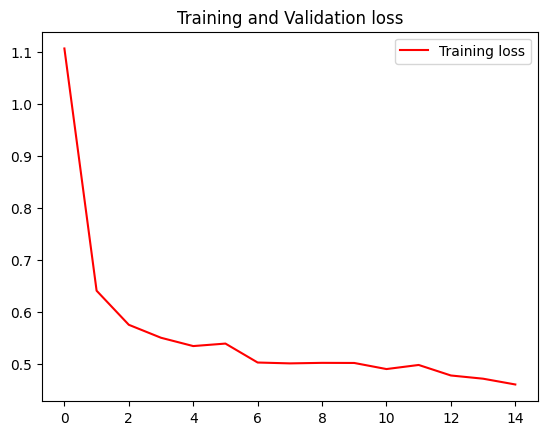

In [23]:
#画train损失图
epochs=range(n_epochs)
plt.plot(epochs, train_total_loss_mean, 'r', label='Training loss')
#plt.plot(epochs, valid_total_loss_mean, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [24]:
def test_model(model, loader):
    """Evaluate the model"""
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            #xs=torch.unsqueeze(xs, dim=-1)
            # push data to GPU (if available)
            # xs=torch.transpose(xs,1,2)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)

    return torch.cat(obs), torch.cat(preds)

In [25]:
# Evaluate on test set
test_times=["2020-05-01 0:00:00","2021-10-09 0:00:00"]
#气象数据
test_average=data_average_df[(data_average_df["time_start"] >= test_times[0]) & (data_average_df["time_start"]<test_times[1])]
#径流数据
test_obs=data_obs_df[(data_obs_df["DATE"] >= test_times[0]) & (data_obs_df["DATE"]<test_times[1])]

In [26]:
# test data
ds_test = sanxiaDataset(
    time=test_times,
    data_obs_df=test_obs,
    data_average_df=test_average,
    loader_type="test",
    seq_length=sequence_length,
    means=means,
    stds=stds,
)
test_batch_size =128
test_loader = DataLoader(ds_test, batch_size=test_batch_size, shuffle=False)
obs, preds = test_model(model, test_loader)
preds = ds_test.local_denormalization(preds.cpu().numpy(), variable="obs_Q")
obs = obs.numpy()
nse = stat(preds,obs)
print("test_nse:",nse)

test_nse: 0.6608204543590546


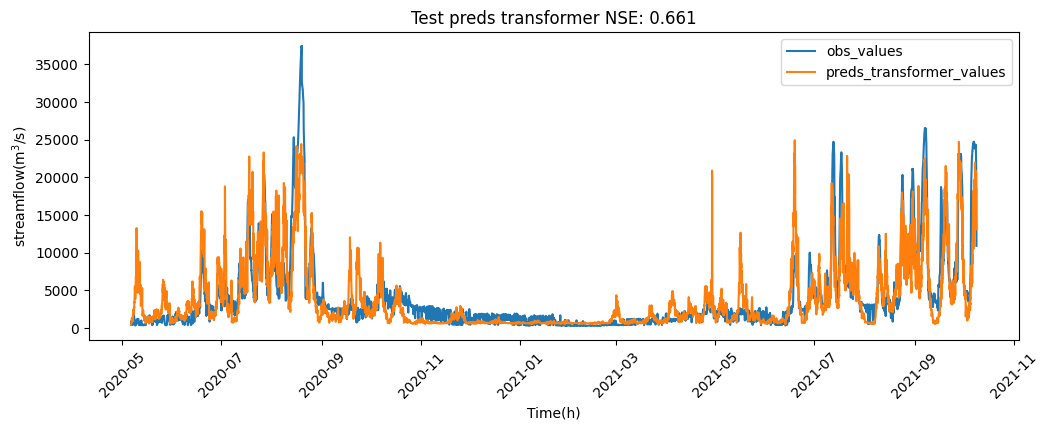

In [27]:
start_date = pd.to_datetime(ds_test.time[0], format='%Y-%m-%d %H:%M:%S') + pd.DateOffset(
    hours=sequence_length - 1
)
end_date = pd.to_datetime(ds_test.time[1], format='%Y-%m-%d %H:%M:%S') - pd.DateOffset(
    hours= 1
)
date_range = pd.date_range(start_date, end_date,freq='h')
#模拟值

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="obs_values")

ax.plot(date_range, preds, label="preds_transformer_values")
ax.legend()
ax.set_title(f"Test preds transformer NSE: {nse:.3f}")
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Time(h)")
_ = ax.set_ylabel("streamflow(m$^{3}$/s)")